# Computing the PCA of a Foreground Object

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [14]:
import pickle
import os
import urllib

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms.functional as TF
from sklearn.decomposition import PCA
from scipy import signal

import random
import tqdm # Progress bar
from sklearn.metrics import pairwise_distances # Isso aqui é para calcular a distancia média entre os patches

DINOV3_GITHUB_LOCATION_LADES = "/home/lades/computer_vision/wesley/dino-soja/dinov3"
DINOV3_GITHUB_LOCATION_GEOIA = "/home/guatambu/Documentos/kanashiro/doutorado/dino-soja/dinov3"

if os.path.exists(DINOV3_GITHUB_LOCATION_LADES):
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION_LADES
elif os.path.exists(DINOV3_GITHUB_LOCATION_GEOIA):
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION_GEOIA
else:
    raise FileNotFoundError("DINOv3 location not found in known paths.")

print(f"DINOv3 location set to {DINOV3_LOCATION}")

# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITL

print(f"Loading DINOv3 model {MODEL_NAME}...")

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local",
    weights="https://huggingface.co/MVRL/dinov3_vitl16_sat/resolve/main/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth"
)
model.cuda()

PATCH_SIZE = 16
IMAGE_SIZE = 256

SATELLITE_MEAN = (0.430, 0.411, 0.296)
SATELLITE_STD = (0.213, 0.156, 0.143)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]
    
def load_image(path: str) -> Image:
    return Image.open(path).convert("RGB")

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

DINOv3 location set to /home/guatambu/Documentos/kanashiro/doutorado/dino-soja/dinov3
Loading DINOv3 model dinov3_vitl16...


In [16]:
# Obter imagem aleatória do dataset

#dataset_path = "/home/lades/computer_vision/wesley/dataset/daninhas_multiclasse/DATASET_CARURU/rgb/"
dataset_path = "/media/guatambu/hdd/wesley/daninhas_multiclasse/DATASET_CARURU/rgb/"
image_uri = f"{dataset_path}{random.choice(os.listdir(dataset_path))}"

print(f"Using image {image_uri}")

# Obtém o respectivo label
label_uri = image_uri.replace("rgb", "labels").replace(".jpg", ".png")
label = np.array(Image.open(label_uri))

print(f"Using label {label_uri}")
np.unique(label)

Using image /media/guatambu/hdd/wesley/daninhas_multiclasse/DATASET_CARURU/rgb/2025-09-17_TH134_06-05-2025_c_mask_6_23364_13070.jpg
Using label /media/guatambu/hdd/wesley/daninhas_multiclasse/DATASET_CARURU/labels/2025-09-17_TH134_06-05-2025_c_mask_6_23364_13070.png


array([  0,   1, 255], dtype=uint8)

In [7]:
def calcular_pca(label, image_uri): 
    # Cria a máscara de foreground (tudo que estiver no fundo preto que seja diferente de branco)
    label_mask = (label == 1).astype(np.float32)
    label_mask = signal.convolve2d(label_mask, np.ones((PATCH_SIZE, PATCH_SIZE)), mode='valid')[::PATCH_SIZE, ::PATCH_SIZE]
    fg_score_mf = torch.from_numpy(label_mask > 0.5)

    image = load_image(image_uri)
    image_resized = resize_transform(image)
    image_resized_norm = TF.normalize(image_resized, mean=SATELLITE_MEAN, std=SATELLITE_STD)

    h_patches, w_patches = image_resized_norm.shape[1] // PATCH_SIZE, image_resized_norm.shape[2] // PATCH_SIZE
    print(f"Image size: {image_resized_norm.shape}, patches: {h_patches}x{w_patches}")

    with torch.inference_mode():
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            feats = model.get_intermediate_layers(image_resized_norm.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
            x = feats[-1].squeeze().detach().cpu()
            dim = x.shape[0]
            x = x.view(dim, -1).permute(1, 0)
            
    fg_patches = x

    pca = PCA(n_components=3, whiten=True)
    pca.fit(fg_patches)

    # apply the PCA, and then reshape
    projected_image = torch.from_numpy(pca.transform(x.numpy())).view(h_patches, w_patches, 3)

    # multiply by 2.0 and pass through a sigmoid to get vibrant colors 
    projected_image = torch.nn.functional.sigmoid(projected_image.mul(2.0)).permute(2, 0, 1)

    # mask the background using the fg_score_mf
    projected_foreground_image = projected_image * (fg_score_mf.unsqueeze(0) > 0.5)
    
    projected_background_image = projected_image * (fg_score_mf.unsqueeze(0) <= 0.5)

    return projected_image, projected_foreground_image, projected_background_image

def plotar_imagens(image_uri, projected_image, projected_foreground_image, label_mask, label_uri):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 5, 1)
    plt.imshow(np.array(Image.open(image_uri)))
    plt.title("Imagem original")
    plt.subplot(1, 5, 2)
    plt.imshow(projected_image.permute(1, 2, 0))
    plt.title("PCA da imagem projetada")
    plt.subplot(1, 5, 3)
    plt.imshow(projected_foreground_image.permute(1, 2, 0))
    plt.title("PCA da imagem projetada + mask")
    plt.subplot(1, 5, 4)
    plt.imshow(np.array(Image.fromarray(label_mask)))
    plt.title("PCA da mask label (GT)")
    plt.subplot(1, 5, 5)
    plt.imshow(Image.open(label_uri))
    plt.title("Label (GT)")
    plt.show()

    # Exibir label_mask com os valores de cada bloquinho
    plt.figure(figsize=(10, 10))
    plt.imshow(label_mask)
    for i in range(label_mask.shape[0]):
        for j in range(label_mask.shape[1]):
            plt.text(j, i, f"{label_mask[i, j]:.1f}", ha='center', va='center', color='white')
    plt.show()

    # Exibir projected_image com os valores de cada bloquinho
    plt.figure(figsize=(10, 10))
    plt.imshow(projected_image.permute(1, 2, 0))
    for i in range(projected_image.shape[1]):
        for j in range(projected_image.shape[2]):
            plt.text(j, i, f"{projected_image[0, i, j]:.1f}", ha='center', va='center', color='white')
    plt.show()

### Experimento
Neste experimento, irei considerar o mask label da respectiva imagem, para separar os patches do PCA da imagem que estiverem dentro da mask label da imagem. Isso sera o foreground e o restante, background.

In [2]:
def extrair_tensores(label, image_uri):
    image = load_image(image_uri)
    image_resized = resize_transform(image)
    image_resized_norm = TF.normalize(image_resized, mean=SATELLITE_MEAN, std=SATELLITE_STD)

    label_mask = (label == 1).astype(np.float32)
    label_mask = signal.convolve2d(label_mask, np.ones((PATCH_SIZE, PATCH_SIZE)), mode='valid')[::PATCH_SIZE, ::PATCH_SIZE]
    fg_score_mf = torch.from_numpy(label_mask > 0.5)

    h_patches, w_patches = image_resized_norm.shape[1] // PATCH_SIZE, image_resized_norm.shape[2] // PATCH_SIZE
    #print(f"Image size: {image_resized_norm.shape}, patches: {h_patches}x{w_patches}")

    with torch.inference_mode():
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            feats = model.get_intermediate_layers(image_resized_norm.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
            x = feats[-1].squeeze().detach().cpu()
            dim = x.shape[0]
            x = x.view(dim, -1).permute(1, 0)
            
    x.shape, fg_score_mf.shape

    # Dividir x em foreground e background, considerando a label_mask
    foreground_x = x[fg_score_mf.view(-1) > 0.5]
    background_x = x[fg_score_mf.view(-1) <= 0.5]

    #print(f'Foreground: {foreground_x.shape}, Background: {background_x.shape}')

    return x, foreground_x, background_x


In [17]:
def agrupar_tensores(dataset_path): # dataset_path deve ser o path do dataset (ex: .../DATASET_CARURU/)
    dataset_path_rgb = f"{dataset_path}/rgb/"
    dataset_path_label = f"{dataset_path}/labels/" # Extensão png
    
    lista_imagens = [f"{dataset_path_rgb}{file}" for file in os.listdir(dataset_path_rgb) if file.endswith('.jpg')]
    lista_labels = [f"{dataset_path_label}{file}" for file in os.listdir(dataset_path_label) if file.endswith('.png')]
    
    lista_imagens.sort()
    lista_labels.sort()

    print(f"Foram encontrados {len(lista_imagens)} imagens e {len(lista_labels)} labels.")

    x_foreground = []
    x_background = []

    # Iterar sobre as imagens utilizando tqdm para mostrar o progresso
    for image_uri, label_uri in tqdm.tqdm(zip(lista_imagens, lista_labels), total=len(lista_imagens)):
        label = np.array(Image.open(label_uri))
        x, foreground, background = extrair_tensores(label, image_uri)
        x_foreground.append(foreground)
        x_background.append(background)

    all_foreground = torch.cat(x_foreground, dim=0)
    all_background = torch.cat(x_background, dim=0)
    
    print(f'Total Foreground: {all_foreground.shape}, Total Background: {all_background.shape}')
    
    return all_foreground, all_background

In [19]:
#dataset_path = "/home/lades/computer_vision/wesley/dataset/daninhas_multiclasse/"
dataset_path = "/media/guatambu/hdd/wesley/daninhas_multiclasse/"

# Obter os nomes das classes, pelo sufixo DATASET_
dir_classes = [d for d in os.listdir(dataset_path) if d.startswith("DATASET_")]

classes = []
for dir_class in dir_classes:
    class_name = dir_class.split("DATASET_")[-1]
    # nickname sera as 3 primeiras letras (se a classe tiver somente uma palavra); ou as iniciais das palavras (se tiver mais de uma palavra)
    if "_" in class_name:
        nickname = "".join([word[0] for word in class_name.split("_")]).upper()
    else:
        nickname = class_name[:3].upper()
    classes.append((class_name, dir_class, nickname))

classes.sort()

classes

[('CARURU', 'DATASET_CARURU', 'CAR'),
 ('GRAMINEA_PORTE_ALTO', 'DATASET_GRAMINEA_PORTE_ALTO', 'GPA'),
 ('GRAMINEA_PORTE_BAIXO', 'DATASET_GRAMINEA_PORTE_BAIXO', 'GPB'),
 ('MAMONA', 'DATASET_MAMONA', 'MAM'),
 ('OUTRAS_FOLHAS_LARGAS', 'DATASET_OUTRAS_FOLHAS_LARGAS', 'OFL'),
 ('TREPADEIRA', 'DATASET_TREPADEIRA', 'TRE')]

In [ ]:
def calcular_distancias_e_desvio_padrao(all_x_foreground, all_x_background, 
                                 max_samples_fg=5000, max_samples_bg=10000):
    """
    Calcula distâncias usando amostragem para economizar memória
    """
    print(f"Original - FG: {all_x_foreground.shape[0]:,}, BG: {all_x_background.shape[0]:,}")
    
    if all_x_foreground.shape[0] > max_samples_fg:
        # Amostrar foreground
        indices_fg = torch.randperm(all_x_foreground.shape[0])[:max_samples_fg]
        fg_sample = all_x_foreground[indices_fg]
        #print(f"Amostrando foreground: {max_samples_fg:,} patches")
    else:
        fg_sample = all_x_foreground
        
    if all_x_background.shape[0] > max_samples_bg:
        # Amostrar background
        indices_bg = torch.randperm(all_x_background.shape[0])[:max_samples_bg]
        bg_sample = all_x_background[indices_bg]
        #print(f"Amostrando background: {max_samples_bg:,} patches")
    else:
        bg_sample = all_x_background
    
    print(f"Calculando distâncias: {fg_sample.shape[0]:,} x {fg_sample.shape[0]:,} (intra)")
    print(f"Calculando distâncias: {fg_sample.shape[0]:,} x {bg_sample.shape[0]:,} (inter)")
    
    # Calcular distâncias nas amostras
    mean_dist_intra = pairwise_distances(fg_sample).mean()
    mean_dist_inter = pairwise_distances(fg_sample, bg_sample).mean()
    std_intra = pairwise_distances(fg_sample).std()
    std_inter = pairwise_distances(fg_sample, bg_sample).std()

    return mean_dist_intra, mean_dist_inter, std_intra, std_inter

: 

In [20]:
def pairwise_distances_torch(x, y=None):
    """
    Uma função wrapper que usa as funções de distância nativas do PyTorch.
    Ela roda na GPU se os tensores de entrada estiverem na GPU.
    """
    if y is None:
        # torch.pdist calcula a distância par-a-par dentro de um único tensor
        return torch.pdist(x)
    else:
        # torch.cdist calcula a distância entre cada par de vetores de dois tensores
        return torch.cdist(x, y)


In [ ]:
def calcular_distancias_otimizado(all_x_foreground, all_x_background, batch_size=256):
    """
    Calcula a média e o desvio padrão das distâncias usando processamento em lotes
    para economizar memória, utilizando 100% dos dados.
    """
    device = all_x_foreground.device # Usa o mesmo dispositivo (CPU ou GPU) dos tensores
    print(f"Iniciando cálculo otimizado com batch size: {batch_size}")
    print(f"Usando dispositivo: {device}")
    
    # --- Cálculo INTRA-CLASSE (foreground vs foreground) ---
    print(f"Calculando distâncias intra-classe para {all_x_foreground.shape[0]:,} vetores...")
    count_intra = 0
    mean_intra = torch.tensor(0.0, device=device)
    M2_intra = torch.tensor(0.0, device=device)

    # Itera sobre os dados em lotes com tqdm
    for i in tqdm.tqdm(range(0, all_x_foreground.shape[0], batch_size), desc="Intra-classe"):
        batch_fg = all_x_foreground[i:i + batch_size]
        
        # Calcula distâncias apenas deste lote contra todos os outros
        dist_batch = pairwise_distances_torch(batch_fg, all_x_foreground)
        
        # Algoritmo de Welford para média e variância online
        for d in dist_batch.flatten(): # Itera sobre cada distância calculada
            count_intra += 1
            delta = d - mean_intra
            mean_intra += delta / count_intra
            delta2 = d - mean_intra
            M2_intra += delta * delta2

    std_intra = torch.sqrt(M2_intra / count_intra) if count_intra > 0 else torch.tensor(0.0)
    
    # --- Cálculo INTER-CLASSE (foreground vs background) ---
    print(f"Calculando distâncias inter-classe para {all_x_foreground.shape[0]:,} vs {all_x_background.shape[0]:,} vetores...")
    count_inter = 0
    mean_inter = torch.tensor(0.0, device=device)
    M2_inter = torch.tensor(0.0, device=device)

    for i in tqdm.tqdm(range(0, all_x_foreground.shape[0], batch_size), desc="Inter-classe"):
        batch_fg = all_x_foreground[i:i + batch_size]
        
        # Calcula distâncias apenas deste lote contra todo o background
        dist_batch = pairwise_distances(batch_fg, all_x_background)
        
        # Algoritmo de Welford
        for d in dist_batch.flatten():
            count_inter += 1
            delta = d - mean_inter
            mean_inter += delta / count_inter
            delta2 = d - mean_inter
            M2_inter += delta * delta2
            
    std_inter = torch.sqrt(M2_inter / count_inter) if count_inter > 0 else torch.tensor(0.0)

    return mean_intra.item(), mean_inter.item(), std_intra.item(), std_inter.item()

In [21]:
def combine_stats(mean_A, M2_A, count_A, mean_B, M2_B, count_B):
    """
    Combina estatísticas de dois conjuntos. A entrada precisa ser dois tensores com média e contagem.
    """
    
    # Iteração inicial
    if count_A == 0:
        return mean_B, M2_B, count_B
    
    if count_B == 0:
        return mean_A, M2_A, count_A
    
    count_total = count_A + count_B
    
    delta = mean_B - mean_A # Diferença
    
    # Média ponderada. N precisa verificar se é maior do que zero, porque já foi verificado antes
    mean_total = (mean_A * count_A + mean_B * count_B) / count_total
    
    # Atualiza M2 usando a fórmula de combinação
    M2_total = M2_A + M2_B + delta * delta * (count_A * count_B) / count_total
    
    return mean_total, M2_total, count_total

def calcular_distancias_otimizado2(all_x_foreground, all_x_background, batch_size=256):
    """
    Esta versão irá calcular as distancias em lotes, utilizando a VRAM (24GB). Como não conseguiremos carregar tudo na VRAM, faremos em lotes.
    A ideia é utilizar a combine_stats para ir acumulando as médias e desvios padrão.
    Essa versão calcula as distancias na VRAM.
    """
    device = all_x_foreground.device # Usa o mesmo dispositivo (CPU ou GPU) dos tensores
    print(f"Iniciando cálculo otimizado com batch size: {batch_size}")
    print(f"Usando dispositivo: {device}")
    
    # --- Cálculo INTRA-CLASSE (foreground vs foreground) ---
    print(f"Calculando distâncias intra-classe para {all_x_foreground.shape[0]:,} vetores...")
    mean_intra = torch.tensor(0.0, device=device, dtype=all_x_foreground.dtype)
    M2_intra = torch.tensor(0.0, device=device, dtype=all_x_foreground.dtype)
    count_intra = torch.tensor(0, device=device, dtype=torch.int64)
    
    # Itera sobre os dados em lotes com tqdm
    for i in tqdm.tqdm(range(0, all_x_foreground.shape[0], batch_size), desc="Intra-classe"):
        batch_fg = all_x_foreground[i:i + batch_size]
                        
        # Calcula distâncias apenas deste lote contra todos os outros
        dist_batch = pairwise_distances_torch(batch_fg, all_x_foreground)
        
        batch_count = torch.tensor(dist_batch.numel(), device=device, dtype=torch.int64)
        
        if batch_count == 0:
            continue

        # Calcula estatísticas do lote atual
        batch_mean = torch.mean(dist_batch)
        
        torch.sub(dist_batch, batch_mean, out=dist_batch)
        torch.pow(dist_batch, 2, out=dist_batch)
        batch_M2 = torch.sum(dist_batch)
        
        # Combina as estatísticas do lote com as acumuladas
        mean_intra, M2_intra, count_intra = combine_stats(mean_intra, M2_intra, count_intra, batch_mean, batch_M2, batch_count)
        
        del dist_batch, batch_mean, batch_M2, batch_count
        torch.cuda.empty_cache()

    std_intra = torch.sqrt(M2_intra / count_intra) if count_intra > 0 else torch.tensor(0.0, device=device, dtype=all_x_foreground.dtype)

    # --- Cálculo INTER-CLASSE (foreground vs background) ---
    print(f"Calculando distâncias inter-classe para {all_x_foreground.shape[0]:,} vs {all_x_background.shape[0]:,} vetores...")
    mean_inter = torch.tensor(0.0, device=device, dtype=all_x_foreground.dtype)
    M2_inter = torch.tensor(0.0, device=device, dtype=all_x_foreground.dtype)
    count_inter = torch.tensor(0, device=device, dtype=torch.int64)
    
    for i in tqdm.tqdm(range(0, all_x_foreground.shape[0], batch_size), desc="Inter-classe"):
        batch_fg = all_x_foreground[i:i + batch_size]
                        
        # Calcula distâncias apenas deste lote contra todo o background
        dist_batch = pairwise_distances_torch(batch_fg, all_x_background)
        
        batch_count = torch.tensor(dist_batch.numel(), device=device, dtype=torch.int64)
        
        if batch_count == 0:
            continue

        # Calcula estatísticas do lote atual
        batch_mean = torch.mean(dist_batch)
        
        torch.sub(dist_batch, batch_mean, out=dist_batch)
        torch.pow(dist_batch, 2, out=dist_batch)
        batch_M2 = torch.sum(dist_batch)
        #batch_M2 = torch.sum((dist_batch - batch_mean) ** 2)
                
        # Combina as estatísticas do lote com as acumuladas
        mean_inter, M2_inter, count_inter = combine_stats(mean_inter, M2_inter, count_inter, batch_mean, batch_M2, batch_count)
        
        del dist_batch, batch_mean, batch_M2, batch_count
        torch.cuda.empty_cache()
        
    std_inter = torch.sqrt(M2_inter / count_inter) if count_inter > 0 else torch.tensor(0.0, device=device, dtype=all_x_foreground.dtype)
    
    return mean_intra.item(), mean_inter.item(), std_intra.item(), std_inter.item()

In [23]:
# Iterar sobre as classes e criar um array unico. Inicialmente conterá todas as all_foreground, all_background, mean_dist_classe_classe e mean_dist_classe_not_classe por classe

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for i, (class_name, dir_class, nickname) in enumerate(classes):
    print(f"Processando classe {class_name} – {nickname}...")
    all_x_foreground, all_x_background = agrupar_tensores(f"{dataset_path}{dir_class}")

    mean_dist_classe_classe, mean_dist_classe_not_classe, std_classe_classe, std_classe_not_classe = calcular_distancias_otimizado2(all_x_foreground.to(device), all_x_background.to(device), batch_size=4096)

    print(f"Distância média {nickname}_{nickname}: {mean_dist_classe_classe}, {nickname}_not_{nickname}: {mean_dist_classe_not_classe}")
    print(f"Desvio padrão {nickname}_{nickname}: {std_classe_classe}, {nickname}_not_{nickname}: {std_classe_not_classe}")

    results.append({
        "class": nickname,
        #"all_foreground": all_x_foreground,
        #"all_background": all_x_background,
        "mean_dist_classe_classe": mean_dist_classe_classe,
        "mean_dist_classe_not_classe": mean_dist_classe_not_classe,
        "std_classe_classe": std_classe_classe,
        "std_classe_not_classe": std_classe_not_classe
    })

    del all_x_foreground, all_x_background
    torch.cuda.empty_cache()
    
    print("\n--------------------------------------------------\n")
    


    

Processando classe CARURU – CAR...
Foram encontrados 97 imagens e 97 labels.


100%|██████████| 97/97 [00:03<00:00, 26.24it/s]


Total Foreground: torch.Size([5205, 1024]), Total Background: torch.Size([19627, 1024])
Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 5,205 vetores...


Intra-classe: 100%|██████████| 2/2 [00:00<00:00, 175.41it/s]


Calculando distâncias inter-classe para 5,205 vs 19,627 vetores...


Inter-classe: 100%|██████████| 2/2 [00:00<00:00, 79.27it/s]


Distância média CAR_CAR: 5.208258152008057, CAR_not_CAR: 5.621340274810791
Desvio padrão CAR_CAR: 0.6591092348098755, CAR_not_CAR: 0.6281547546386719

--------------------------------------------------

Processando classe GRAMINEA_PORTE_ALTO – GPA...
Foram encontrados 2726 imagens e 2726 labels.


100%|██████████| 2726/2726 [02:00<00:00, 22.55it/s]


Total Foreground: torch.Size([27369, 1024]), Total Background: torch.Size([670487, 1024])
Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 27,369 vetores...


Intra-classe: 100%|██████████| 7/7 [00:00<00:00, 36.91it/s]


Calculando distâncias inter-classe para 27,369 vs 670,487 vetores...


Inter-classe: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Distância média GPA_GPA: 6.253508567810059, GPA_not_GPA: 6.467997074127197
Desvio padrão GPA_GPA: 1.2309958934783936, GPA_not_GPA: 1.2288106679916382

--------------------------------------------------

Processando classe GRAMINEA_PORTE_BAIXO – GPB...
Foram encontrados 1747 imagens e 1747 labels.


100%|██████████| 1747/1747 [01:19<00:00, 21.97it/s]


Total Foreground: torch.Size([15705, 1024]), Total Background: torch.Size([431527, 1024])
Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 15,705 vetores...


Intra-classe: 100%|██████████| 4/4 [00:00<00:00, 59.68it/s]


Calculando distâncias inter-classe para 15,705 vs 431,527 vetores...


Inter-classe: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


Distância média GPB_GPB: 5.881474018096924, GPB_not_GPB: 6.172074317932129
Desvio padrão GPB_GPB: 0.66194748878479, GPB_not_GPB: 0.5907758474349976

--------------------------------------------------

Processando classe MAMONA – MAM...
Foram encontrados 1103 imagens e 1103 labels.


100%|██████████| 1103/1103 [00:51<00:00, 21.53it/s]


Total Foreground: torch.Size([10524, 1024]), Total Background: torch.Size([271844, 1024])
Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 10,524 vetores...


Intra-classe: 100%|██████████| 3/3 [00:00<00:00, 84.36it/s]


Calculando distâncias inter-classe para 10,524 vs 271,844 vetores...


Inter-classe: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


Distância média MAM_MAM: 7.103963851928711, MAM_not_MAM: 7.037497043609619
Desvio padrão MAM_MAM: 4.074458122253418, MAM_not_MAM: 3.205545663833618

--------------------------------------------------

Processando classe OUTRAS_FOLHAS_LARGAS – OFL...
Foram encontrados 2999 imagens e 2999 labels.


100%|██████████| 2999/2999 [02:25<00:00, 20.59it/s]


Total Foreground: torch.Size([28817, 1024]), Total Background: torch.Size([738927, 1024])
Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 28,817 vetores...


Intra-classe: 100%|██████████| 8/8 [00:00<00:00, 38.92it/s]


Calculando distâncias inter-classe para 28,817 vs 738,927 vetores...


Inter-classe: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Distância média OFL_OFL: 6.131234169006348, OFL_not_OFL: 6.289871692657471
Desvio padrão OFL_OFL: 1.0129647254943848, OFL_not_OFL: 0.8847392201423645

--------------------------------------------------

Processando classe TREPADEIRA – TRE...
Foram encontrados 2320 imagens e 2320 labels.


100%|██████████| 2320/2320 [01:47<00:00, 21.61it/s]


Total Foreground: torch.Size([38800, 1024]), Total Background: torch.Size([555120, 1024])
Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 38,800 vetores...


Intra-classe: 100%|██████████| 10/10 [00:00<00:00, 29.22it/s]


Calculando distâncias inter-classe para 38,800 vs 555,120 vetores...


Inter-classe: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

Distância média TRE_TRE: 5.7882866859436035, TRE_not_TRE: 6.364722728729248
Desvio padrão TRE_TRE: 0.71458899974823, TRE_not_TRE: 1.005866289138794

--------------------------------------------------



### Experimento 2: Foreground será a mask das imagens da classe e Background será a mask das imagens das outras classes

In [25]:
# Cria uma lista apenas com os tensores (foreground) de cada classe

foreground_tensors_per_class = []

for i, (class_name, dir_class, nickname) in enumerate(classes):
    all_x_foreground, all_x_background = agrupar_tensores(f"{dataset_path}{dir_class}")
    
    # Adiciona o foreground e o nome da classe na lista
    foreground_tensors_per_class.append((nickname, all_x_foreground))
    
    del all_x_foreground, all_x_background
    torch.cuda.empty_cache()
    

Foram encontrados 97 imagens e 97 labels.


100%|██████████| 97/97 [00:03<00:00, 27.65it/s]


Total Foreground: torch.Size([5205, 1024]), Total Background: torch.Size([19627, 1024])
Foram encontrados 2726 imagens e 2726 labels.


100%|██████████| 2726/2726 [01:41<00:00, 26.93it/s]


Total Foreground: torch.Size([27369, 1024]), Total Background: torch.Size([670487, 1024])
Foram encontrados 1747 imagens e 1747 labels.


100%|██████████| 1747/1747 [01:06<00:00, 26.42it/s]


Total Foreground: torch.Size([15705, 1024]), Total Background: torch.Size([431527, 1024])
Foram encontrados 1103 imagens e 1103 labels.


100%|██████████| 1103/1103 [00:41<00:00, 26.61it/s]


Total Foreground: torch.Size([10524, 1024]), Total Background: torch.Size([271844, 1024])
Foram encontrados 2999 imagens e 2999 labels.


100%|██████████| 2999/2999 [01:52<00:00, 26.71it/s]


Total Foreground: torch.Size([28817, 1024]), Total Background: torch.Size([738927, 1024])
Foram encontrados 2320 imagens e 2320 labels.


100%|██████████| 2320/2320 [01:27<00:00, 26.58it/s]


Total Foreground: torch.Size([38800, 1024]), Total Background: torch.Size([555120, 1024])


In [36]:
classes[0]

('CARURU', 'DATASET_CARURU', 'CAR')

In [37]:

# all_x_foreground é o que está na coluna 1 de cada linha de foreground_tensors_per_class
# all_x_background é o que está na coluna 1 de todas as linhas, com exceção da referida linha de foreground_tensors_per_class

# Matriz de distâncias entre todas as classes
mean_dists = np.zeros((len(foreground_tensors_per_class), len(foreground_tensors_per_class)))
stds = np.zeros((len(foreground_tensors_per_class), len(foreground_tensors_per_class)))

for i in range(len(foreground_tensors_per_class)):
    print(f"Classe {foreground_tensors_per_class[i][0]}: {foreground_tensors_per_class[i][1].shape[0]:,} patches de foreground\n")
    
    nickname_fg = foreground_tensors_per_class[i][0]

    all_x_foreground = foreground_tensors_per_class[i][1]

    for j in range(len(foreground_tensors_per_class)):
        if i == j: # Desconsidera a própria classe
            continue
        
        all_x_background = foreground_tensors_per_class[j][1]
        nickname_bg = foreground_tensors_per_class[j][0]

        mean_dists[i][i], mean_dists[i][j], stds[i][i], stds[i][j] = calcular_distancias_otimizado2(all_x_foreground.to(device), all_x_background.to(device), batch_size=4096)

        print(f"Distância média {nickname_fg}_{nickname_fg}: {mean_dists[i][i]}, {nickname_fg}_{nickname_bg}: {mean_dists[i][j]}")
        print(f"Desvio padrão {nickname_fg}_{nickname_fg}: {stds[i][i]}, {nickname_fg}_{nickname_bg}: {stds[i][j]}")
        
        print("\n--------------------------------------------------\n")

Classe CAR: 5,205 patches de foreground

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 5,205 vetores...


Intra-classe: 100%|██████████| 2/2 [00:00<00:00, 306.38it/s]


Calculando distâncias inter-classe para 5,205 vs 27,369 vetores...


Inter-classe: 100%|██████████| 2/2 [00:00<00:00, 76.91it/s]


Distância média CAR_CAR: 5.20556640625, CAR_GPA: 6.352621078491211
Desvio padrão CAR_CAR: 0.6603983640670776, CAR_GPA: 0.8972669243812561

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 5,205 vetores...


Intra-classe: 100%|██████████| 2/2 [00:00<00:00, 369.09it/s]


Calculando distâncias inter-classe para 5,205 vs 15,705 vetores...


Inter-classe: 100%|██████████| 2/2 [00:00<00:00, 145.64it/s]


Distância média CAR_CAR: 5.20556640625, CAR_GPB: 6.187222957611084
Desvio padrão CAR_CAR: 0.6603983640670776, CAR_GPB: 0.535916805267334

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 5,205 vetores...


Intra-classe: 100%|██████████| 2/2 [00:00<00:00, 338.26it/s]


Calculando distâncias inter-classe para 5,205 vs 10,524 vetores...


Inter-classe: 100%|██████████| 2/2 [00:00<00:00, 206.51it/s]


Distância média CAR_CAR: 5.20556640625, CAR_MAM: 6.824066638946533
Desvio padrão CAR_CAR: 0.6603983640670776, CAR_MAM: 2.9573349952697754

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 5,205 vetores...


Intra-classe: 100%|██████████| 2/2 [00:00<00:00, 378.55it/s]


Calculando distâncias inter-classe para 5,205 vs 28,817 vetores...


Inter-classe: 100%|██████████| 2/2 [00:00<00:00, 75.34it/s]


Distância média CAR_CAR: 5.20556640625, CAR_OFL: 6.028558731079102
Desvio padrão CAR_CAR: 0.6603983640670776, CAR_OFL: 0.8702014684677124

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 5,205 vetores...


Intra-classe: 100%|██████████| 2/2 [00:00<00:00, 332.80it/s]


Calculando distâncias inter-classe para 5,205 vs 38,800 vetores...


Inter-classe: 100%|██████████| 2/2 [00:00<00:00, 56.08it/s]


Distância média CAR_CAR: 5.20556640625, CAR_TRE: 6.054257869720459
Desvio padrão CAR_CAR: 0.6603983640670776, CAR_TRE: 0.4923448860645294

--------------------------------------------------

Classe GPA: 27,369 patches de foreground

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 27,369 vetores...


Intra-classe: 100%|██████████| 7/7 [00:00<00:00, 52.69it/s]


Calculando distâncias inter-classe para 27,369 vs 5,205 vetores...


Inter-classe: 100%|██████████| 7/7 [00:00<00:00, 271.67it/s]


Distância média GPA_GPA: 6.2526702880859375, GPA_CAR: 6.352621078491211
Desvio padrão GPA_GPA: 1.2301595211029053, GPA_CAR: 0.8972669839859009

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 27,369 vetores...


Intra-classe: 100%|██████████| 7/7 [00:00<00:00, 52.24it/s]


Calculando distâncias inter-classe para 27,369 vs 15,705 vetores...


Inter-classe: 100%|██████████| 7/7 [00:00<00:00, 81.25it/s]


Distância média GPA_GPA: 6.2526702880859375, GPA_GPB: 6.354570388793945
Desvio padrão GPA_GPA: 1.2301595211029053, GPA_GPB: 0.9352080225944519

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 27,369 vetores...


Intra-classe: 100%|██████████| 7/7 [00:00<00:00, 52.39it/s]


Calculando distâncias inter-classe para 27,369 vs 10,524 vetores...


Inter-classe: 100%|██████████| 7/7 [00:00<00:00, 140.23it/s]


Distância média GPA_GPA: 6.2526702880859375, GPA_MAM: 7.010115623474121
Desvio padrão GPA_GPA: 1.2301595211029053, GPA_MAM: 3.0026650428771973

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 27,369 vetores...


Intra-classe: 100%|██████████| 7/7 [00:00<00:00, 52.54it/s]


Calculando distâncias inter-classe para 27,369 vs 28,817 vetores...


Inter-classe: 100%|██████████| 7/7 [00:00<00:00, 48.96it/s]


Distância média GPA_GPA: 6.2526702880859375, GPA_OFL: 6.371471405029297
Desvio padrão GPA_GPA: 1.2301595211029053, GPA_OFL: 1.079814076423645

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 27,369 vetores...


Intra-classe: 100%|██████████| 7/7 [00:00<00:00, 51.67it/s]


Calculando distâncias inter-classe para 27,369 vs 38,800 vetores...


Inter-classe: 100%|██████████| 7/7 [00:00<00:00, 36.51it/s]


Distância média GPA_GPA: 6.2526702880859375, GPA_TRE: 6.2979841232299805
Desvio padrão GPA_GPA: 1.2301595211029053, GPA_TRE: 0.9301158785820007

--------------------------------------------------

Classe GPB: 15,705 patches de foreground

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 15,705 vetores...


Intra-classe: 100%|██████████| 4/4 [00:00<00:00, 97.82it/s]


Calculando distâncias inter-classe para 15,705 vs 5,205 vetores...


Inter-classe: 100%|██████████| 4/4 [00:00<00:00, 260.33it/s]


Distância média GPB_GPB: 5.88023567199707, GPB_CAR: 6.187223434448242
Desvio padrão GPB_GPB: 0.6611127853393555, GPB_CAR: 0.5359168648719788

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 15,705 vetores...


Intra-classe: 100%|██████████| 4/4 [00:00<00:00, 91.82it/s]


Calculando distâncias inter-classe para 15,705 vs 27,369 vetores...


Inter-classe: 100%|██████████| 4/4 [00:00<00:00, 53.33it/s]


Distância média GPB_GPB: 5.88023567199707, GPB_GPA: 6.354570388793945
Desvio padrão GPB_GPB: 0.6611127853393555, GPB_GPA: 0.9352080225944519

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 15,705 vetores...


Intra-classe: 100%|██████████| 4/4 [00:00<00:00, 98.40it/s]


Calculando distâncias inter-classe para 15,705 vs 10,524 vetores...


Inter-classe: 100%|██████████| 4/4 [00:00<00:00, 139.06it/s]


Distância média GPB_GPB: 5.88023567199707, GPB_MAM: 6.804374694824219
Desvio padrão GPB_GPB: 0.6611127853393555, GPB_MAM: 2.9487812519073486

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 15,705 vetores...


Intra-classe: 100%|██████████| 4/4 [00:00<00:00, 88.30it/s]


Calculando distâncias inter-classe para 15,705 vs 28,817 vetores...


Inter-classe: 100%|██████████| 4/4 [00:00<00:00, 48.66it/s]


Distância média GPB_GPB: 5.88023567199707, GPB_OFL: 6.1413960456848145
Desvio padrão GPB_GPB: 0.6611127853393555, GPB_OFL: 0.7973529100418091

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 15,705 vetores...


Intra-classe: 100%|██████████| 4/4 [00:00<00:00, 85.43it/s]


Calculando distâncias inter-classe para 15,705 vs 38,800 vetores...


Inter-classe: 100%|██████████| 4/4 [00:00<00:00, 36.87it/s]


Distância média GPB_GPB: 5.88023567199707, GPB_TRE: 6.2276930809021
Desvio padrão GPB_GPB: 0.6611127853393555, GPB_TRE: 0.5107511878013611

--------------------------------------------------

Classe MAM: 10,524 patches de foreground

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 10,524 vetores...


Intra-classe: 100%|██████████| 3/3 [00:00<00:00, 155.14it/s]


Calculando distâncias inter-classe para 10,524 vs 5,205 vetores...


Inter-classe: 100%|██████████| 3/3 [00:00<00:00, 284.57it/s]


Distância média MAM_MAM: 7.103199481964111, MAM_CAR: 6.824066638946533
Desvio padrão MAM_MAM: 4.061670303344727, MAM_CAR: 2.9573352336883545

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 10,524 vetores...


Intra-classe: 100%|██████████| 3/3 [00:00<00:00, 151.19it/s]


Calculando distâncias inter-classe para 10,524 vs 27,369 vetores...


Inter-classe: 100%|██████████| 3/3 [00:00<00:00, 56.47it/s]


Distância média MAM_MAM: 7.103199481964111, MAM_GPA: 7.010114669799805
Desvio padrão MAM_MAM: 4.061670303344727, MAM_GPA: 3.0026652812957764

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 10,524 vetores...


Intra-classe: 100%|██████████| 3/3 [00:00<00:00, 147.68it/s]


Calculando distâncias inter-classe para 10,524 vs 15,705 vetores...


Inter-classe: 100%|██████████| 3/3 [00:00<00:00, 108.37it/s]


Distância média MAM_MAM: 7.103199481964111, MAM_GPB: 6.804374694824219
Desvio padrão MAM_MAM: 4.061670303344727, MAM_GPB: 2.9487814903259277

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 10,524 vetores...


Intra-classe: 100%|██████████| 3/3 [00:00<00:00, 155.02it/s]


Calculando distâncias inter-classe para 10,524 vs 28,817 vetores...


Inter-classe: 100%|██████████| 3/3 [00:00<00:00, 57.07it/s]


Distância média MAM_MAM: 7.103199481964111, MAM_OFL: 6.785893440246582
Desvio padrão MAM_MAM: 4.061670303344727, MAM_OFL: 3.012302875518799

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 10,524 vetores...


Intra-classe: 100%|██████████| 3/3 [00:00<00:00, 155.89it/s]


Calculando distâncias inter-classe para 10,524 vs 38,800 vetores...


Inter-classe: 100%|██████████| 3/3 [00:00<00:00, 42.05it/s]


Distância média MAM_MAM: 7.103199481964111, MAM_TRE: 6.8327860832214355
Desvio padrão MAM_MAM: 4.061670303344727, MAM_TRE: 2.939757823944092

--------------------------------------------------

Classe OFL: 28,817 patches de foreground

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 28,817 vetores...


Intra-classe: 100%|██████████| 8/8 [00:00<00:00, 52.91it/s]


Calculando distâncias inter-classe para 28,817 vs 5,205 vetores...


Inter-classe: 100%|██████████| 8/8 [00:00<00:00, 291.64it/s]

Distância média OFL_OFL: 6.130853652954102, OFL_CAR: 6.028558254241943
Desvio padrão OFL_OFL: 1.0069572925567627, OFL_CAR: 0.8702014684677124

--------------------------------------------------



Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 28,817 vetores...


Intra-classe: 100%|██████████| 8/8 [00:00<00:00, 52.86it/s]


Calculando distâncias inter-classe para 28,817 vs 27,369 vetores...


Inter-classe: 100%|██████████| 8/8 [00:00<00:00, 56.41it/s]


Distância média OFL_OFL: 6.130853652954102, OFL_GPA: 6.371471405029297
Desvio padrão OFL_OFL: 1.0069572925567627, OFL_GPA: 1.079814076423645

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 28,817 vetores...


Intra-classe: 100%|██████████| 8/8 [00:00<00:00, 53.98it/s]


Calculando distâncias inter-classe para 28,817 vs 15,705 vetores...


Inter-classe: 100%|██████████| 8/8 [00:00<00:00, 88.69it/s]


Distância média OFL_OFL: 6.130853652954102, OFL_GPB: 6.1413960456848145
Desvio padrão OFL_OFL: 1.0069572925567627, OFL_GPB: 0.7973529100418091

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 28,817 vetores...


Intra-classe: 100%|██████████| 8/8 [00:00<00:00, 53.45it/s]


Calculando distâncias inter-classe para 28,817 vs 10,524 vetores...


Inter-classe: 100%|██████████| 8/8 [00:00<00:00, 154.06it/s]


Distância média OFL_OFL: 6.130853652954102, OFL_MAM: 6.78589391708374
Desvio padrão OFL_OFL: 1.0069572925567627, OFL_MAM: 3.012302875518799

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 28,817 vetores...


Intra-classe: 100%|██████████| 8/8 [00:00<00:00, 54.21it/s]


Calculando distâncias inter-classe para 28,817 vs 38,800 vetores...


Inter-classe: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s]


Distância média OFL_OFL: 6.130853652954102, OFL_TRE: 6.20745849609375
Desvio padrão OFL_OFL: 1.0069572925567627, OFL_TRE: 0.7691168189048767

--------------------------------------------------

Classe TRE: 38,800 patches de foreground

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 38,800 vetores...


Intra-classe: 100%|██████████| 10/10 [00:00<00:00, 37.07it/s]


Calculando distâncias inter-classe para 38,800 vs 5,205 vetores...


Inter-classe: 100%|██████████| 10/10 [00:00<00:00, 269.53it/s]


Distância média TRE_TRE: 5.786174774169922, TRE_CAR: 6.054257869720459
Desvio padrão TRE_TRE: 0.7154551148414612, TRE_CAR: 0.4923449456691742

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 38,800 vetores...


Intra-classe: 100%|██████████| 10/10 [00:00<00:00, 37.42it/s]


Calculando distâncias inter-classe para 38,800 vs 27,369 vetores...


Inter-classe: 100%|██████████| 10/10 [00:00<00:00, 52.30it/s]


Distância média TRE_TRE: 5.786174774169922, TRE_GPA: 6.2979841232299805
Desvio padrão TRE_TRE: 0.7154551148414612, TRE_GPA: 0.9301159381866455

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 38,800 vetores...


Intra-classe: 100%|██████████| 10/10 [00:00<00:00, 37.01it/s]


Calculando distâncias inter-classe para 38,800 vs 15,705 vetores...


Inter-classe: 100%|██████████| 10/10 [00:00<00:00, 84.25it/s]


Distância média TRE_TRE: 5.786174774169922, TRE_GPB: 6.227692604064941
Desvio padrão TRE_TRE: 0.7154551148414612, TRE_GPB: 0.5107512474060059

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 38,800 vetores...


Intra-classe: 100%|██████████| 10/10 [00:00<00:00, 37.06it/s]


Calculando distâncias inter-classe para 38,800 vs 10,524 vetores...


Inter-classe: 100%|██████████| 10/10 [00:00<00:00, 141.90it/s]


Distância média TRE_TRE: 5.786174774169922, TRE_MAM: 6.832787036895752
Desvio padrão TRE_TRE: 0.7154551148414612, TRE_MAM: 2.939758062362671

--------------------------------------------------

Iniciando cálculo otimizado com batch size: 4096
Usando dispositivo: cuda:0
Calculando distâncias intra-classe para 38,800 vetores...


Intra-classe: 100%|██████████| 10/10 [00:00<00:00, 36.67it/s]


Calculando distâncias inter-classe para 38,800 vs 28,817 vetores...


Inter-classe: 100%|██████████| 10/10 [00:00<00:00, 50.64it/s]

Distância média TRE_TRE: 5.786174774169922, TRE_OFL: 6.20745849609375
Desvio padrão TRE_TRE: 0.7154551148414612, TRE_OFL: 0.7691168189048767

--------------------------------------------------



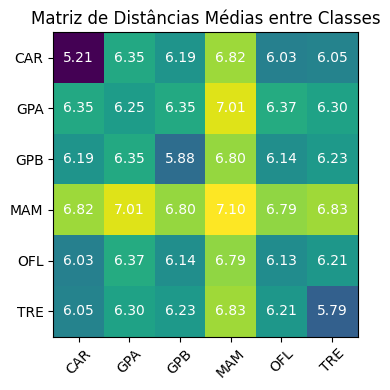

In [52]:
# Plotar a matriz de distâncias médias entre classes 
plt.figure(figsize=(6, 4))
plt.imshow(mean_dists, cmap='viridis')

# Adiciona o valor de cada célula na matriz
for i in range(mean_dists.shape[0]):
    for j in range(mean_dists.shape[1]):
        plt.text(j, i, f"{mean_dists[i, j]:.2f}", ha='center', va='center', color='white')

plt.xticks(ticks=np.arange(len(foreground_tensors_per_class)), labels=[t[0] for t in foreground_tensors_per_class], rotation=45)
plt.yticks(ticks=np.arange(len(foreground_tensors_per_class)), labels=[t[0] for t in foreground_tensors_per_class])
plt.title('Matriz de Distâncias Médias entre Classes')
plt.tight_layout()
plt.show()